# Churn Prediction with PySpark

**This tutorial is created by [Baligh Mnassri](https://github.com/mnassrib). It is inspired from that realized by [Ben Sadeghi](https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/). This work is improved, extended and adapted to be running on the [databricks cloud](https://databricks.com/try-databricks). It presents six classifiers that will be compared at the cross validation part. I will explain how to compute the different evaluate metrics on the binary classification case.**

The studied classifiers are:
* Logistic regression
* Naive Bayes
* Linear Support Vector Machine
* Decision tree classifier
* Random forest classifier
* Gradient-boosted tree classifier

Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals.

The prediction process is heavily data driven and often utilizes advanced machine learning techniques. In this post, we will take a look at what types of customer data are typically used, do some preliminary analysis of the data, and generate churn prediction models - all with PySpark and its machine learning frameworks. We will also discuss the differences between two Apache Spark frameworks, MLlib and ML.

## Initializing a Spark session

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

## Fetching and Importing Churn Data

For this tutorial, we will be using the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The data can be fetched from BigML's S3 bucket, [churn-80](https://bml-data.s3.amazonaws.com/churn-bigml-80.csv) and [churn-20](https://bml-data.s3.amazonaws.com/churn-bigml-20.csv). They can be dowloaded and uploaded to [databricks cloud](https://docs.databricks.com/user-guide/importing-data.html#import-data).
 
The two sets are from the same batch, but have been split by an 80/20 ratio. We will use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation. 

In order to read the CSV data and parse it into Spark [DataFrames](http://spark.apache.org/docs/latest/sql-programming-guide.html), we will use the [CSV package](https://github.com/databricks/spark-csv). 

Let's load the two CSV datasets into Dataframes, keeping the header information and caching them into memory for quick, repeated access. We will also print the schema of the sets.

In [5]:
CV_data = spark.read.csv('/FileStore/tables/churn_bigml_80-bf1a8.csv', header='true', inferSchema='true')

final_test_data = spark.read.csv('/FileStore/tables/churn_bigml_20-55239.csv', header='true', inferSchema='true')

CV_data.printSchema()

root
-- State: string (nullable = true)
-- Account length: integer (nullable = true)
-- Area code: integer (nullable = true)
-- International plan: string (nullable = true)
-- Voice mail plan: string (nullable = true)
-- Number vmail messages: integer (nullable = true)
-- Total day minutes: double (nullable = true)
-- Total day calls: integer (nullable = true)
-- Total day charge: double (nullable = true)
-- Total eve minutes: double (nullable = true)
-- Total eve calls: integer (nullable = true)
-- Total eve charge: double (nullable = true)
-- Total night minutes: double (nullable = true)
-- Total night calls: integer (nullable = true)
-- Total night charge: double (nullable = true)
-- Total intl minutes: double (nullable = true)
-- Total intl calls: integer (nullable = true)
-- Total intl charge: double (nullable = true)
-- Customer service calls: integer (nullable = true)
-- Churn: boolean (nullable = true)

In [6]:
print("The training dataset contains {} samples.".format(CV_data.count()))
print("The test dataset contains {} samples.".format(final_test_data.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.

By taking 5 rows of the ``CV_data`` variable and generating a Pandas Dataframe with them, we can get a display of what the rows look like. We are using Pandas instead of the Spark ``DataFrame.show()`` function because it creates a prettier print.

In [8]:
CV_data.select("*").toPandas().head().transpose()

Out[ 4 ]: 
 0 1 2 3 4
State KS OH NJ OH OK
Account length 128 107 137 84 75
Area code 415 415 415 408 415
International plan No No No Yes Yes
Voice mail plan Yes Yes No No No
Number vmail messages 25 26 0 0 0
Total day minutes 265.1 161.6 243.4 299.4 166.7
Total day calls 110 123 114 71 113
Total day charge 45.07 27.47 41.38 50.9 28.34
Total eve minutes 197.4 195.5 121.2 61.9 148.3
Total eve calls 99 103 110 88 122
Total eve charge 16.78 16.62 10.3 5.26 12.61
Total night minutes 244.7 254.4 162.6 196.9 186.9
Total night calls 91 103 104 89 121
Total night charge 11.01 11.45 7.32 8.86 8.41
Total intl minutes 10 13.7 12.2 6.6 10.1
Total intl calls 3 3 5 7 3
Total intl charge 2.7 3.7 3.29 1.78 2.73
Customer service calls 1 1 0 2 3
Churn False False False False False

## Summary Statistics

Spark DataFrames include some [built-in functions](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) for statistical processing. The ``describe()`` function performs summary statistics calculations on all numeric columns, and returns them as a Dataframe.

In [10]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

CV_data.describe(numeric_features).toPandas().transpose()

Out[ 5 ]: 
 0 1 2 3 \
summary count mean stddev min 
Account length 2666 100.62040510127532 39.56397365334985 1 
Area code 2666 437.43885971492875 42.521018019427174 408 
Number vmail messages 2666 8.021755438859715 13.61227701829193 0 
Total day minutes 2666 179.48162040510135 54.21035022086982 0.0 
Total day calls 2666 100.31020255063765 19.988162186059512 0 
Total day charge 2666 30.512404351087813 9.215732907163497 0.0 
Total eve minutes 2666 200.38615903976006 50.95151511764598 0.0 
Total eve calls 2666 100.02363090772693 20.16144511531889 0 
Total eve charge 2666 17.033072018004518 4.330864176799864 0.0 
Total night minutes 2666 201.16894223555968 50.780323368725206 43.7 
Total night calls 2666 100.10615153788447 19.418458551101697 33 
Total night charge 2666 9.052689422355604 2.2851195129157564 1.97 
Total intl minutes 2666 10.23702175543886 2.7883485770512566 0.0 
Total intl calls 2666 4.467366841710428 2.4561949030129466 0 
Total intl charge 2666 2.764489872468112 0.7528120531228477 0.0 
Customer service calls 2666 1.5626406601650413 1.3112357589949093 0 

 4 
summary max 
Account length 243 
Area code 510 
Number vmail messages 50 
Total day minutes 350.8 
Total day calls 160 
Total day charge 59.64 
Total eve minutes 363.7 
Total eve calls 170 
Total eve charge 30.91 
Total night minutes 395.0 
Total night calls 166 
Total night charge 17.77 
Total intl minutes 20.0 
Total intl calls 20 
Total intl charge 5.4 
Customer service calls 9

## Correlations and Data Preparation

We can also perform our own statistical analyses, using the [seaborn package](https://seaborn.pydata.org/) or other python packages. Indeed, we are use this library to examine correlations between the numeric columns by generating scatter plots of them.

Because the required execution time, we will randomly sample a portion of the data (say 10%) to get a rough idea of how it looks.

In [12]:
sampled_data = CV_data.select(numeric_features).sample(False, 0.10)

print("The sampled dataset contains {} samples.".format(sampled_data.count()))

The sampled dataset contains 300 samples.

It is ready to generate the scatter plots:

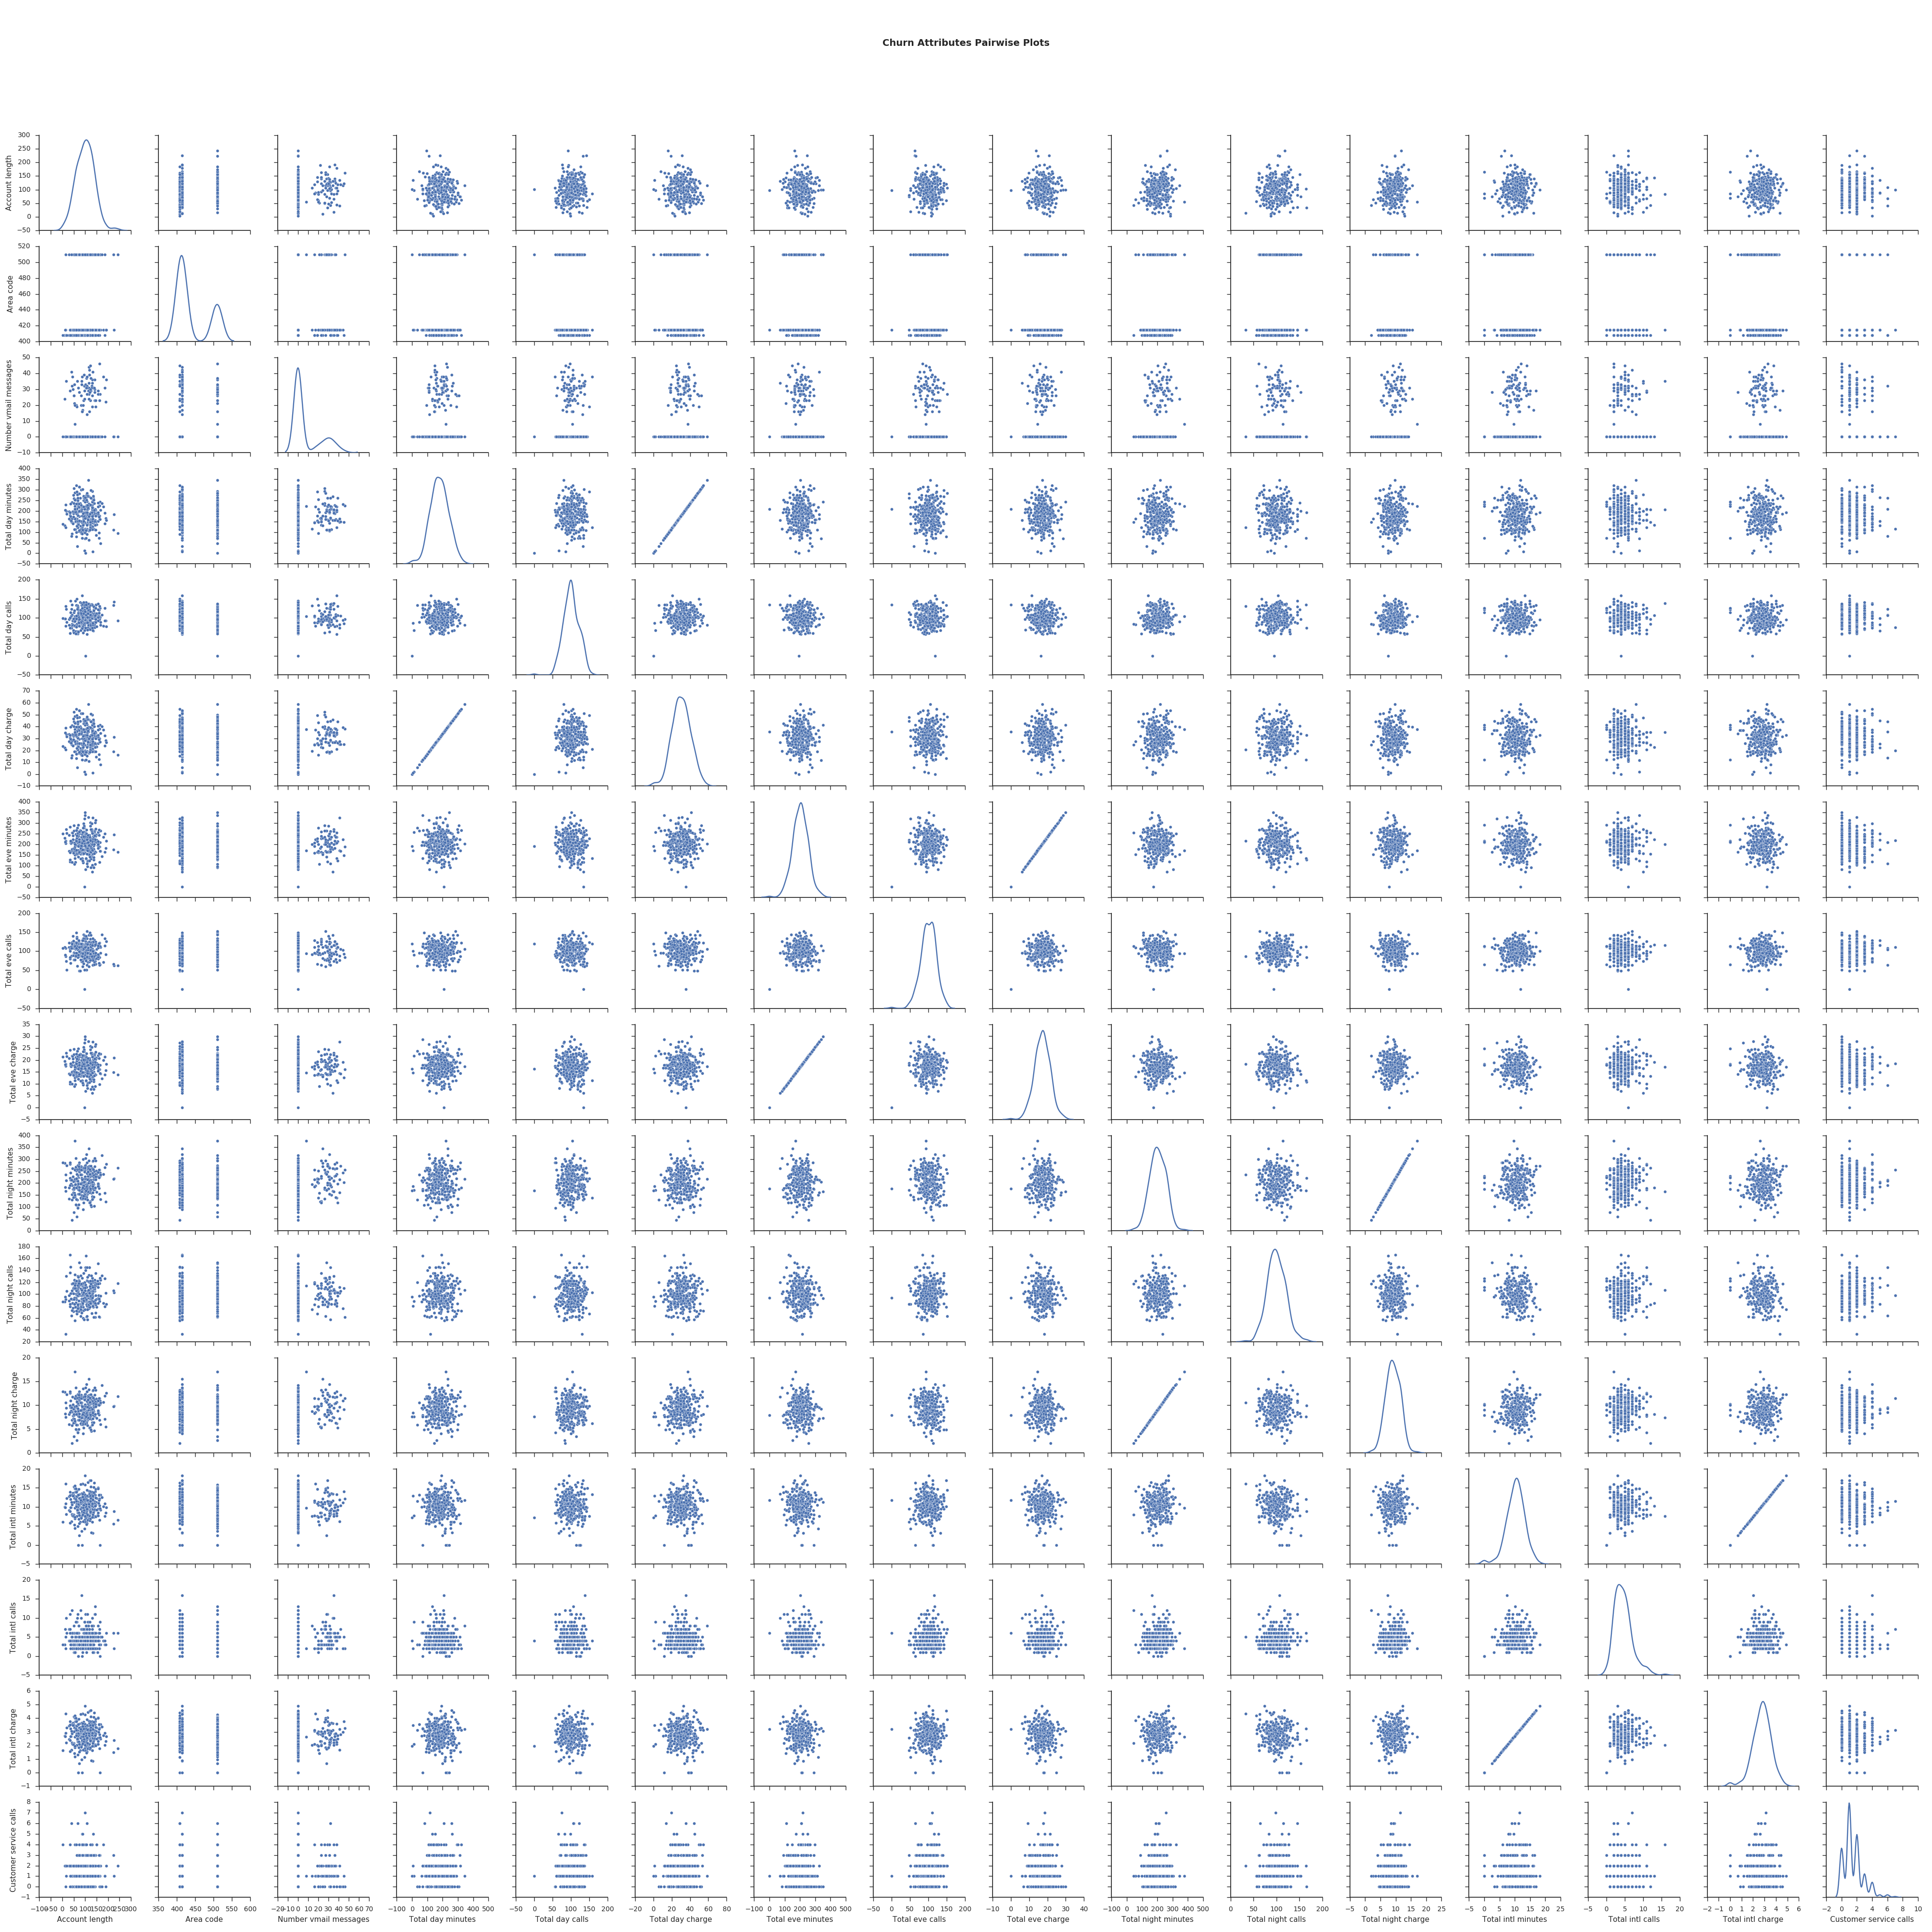

In [14]:
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Churn Attributes Pairwise Plots', fontsize=14, fontweight='bold')

display(fig)

It's obvious that there are several highly correlated fields, *ie* ``Total day minutes`` and ``Total day charge``. Such correlated data will not be very beneficial for the model training runs, so we are going to remove them. We will do so by dropping one column of each pair of correlated variables along with the ``State`` and ``Area code`` columns.

While we are in the process of manipulating the datasets, let's transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps ``Yes``/``True`` and ``No``/``False`` to ``1`` and ``0``, respectively. All these tasks will be done using the following ``get_data`` function.

In [16]:
def get_data(df, removeCols):
  df = df.drop(*removeCols) \
    .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
    .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
    .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
  return df

In [17]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

CV_data = get_data(CV_data, removeCols=removeCols)
final_test_data = get_data(final_test_data, removeCols=removeCols)

Let's take a quick look at the resulting datasets.

In [19]:
import pandas as pd
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

Out[ 10 ]: 
 0 1 2 3 4
Account length 128.0 107.0 137.0 84.0 75.0
International plan 0.0 0.0 0.0 1.0 1.0
Voice mail plan 1.0 1.0 0.0 0.0 0.0
Number vmail messages 25.0 26.0 0.0 0.0 0.0
Total day minutes 265.1 161.6 243.4 299.4 166.7
Total day calls 110.0 123.0 114.0 71.0 113.0
Total eve minutes 197.4 195.5 121.2 61.9 148.3
Total eve calls 99.0 103.0 110.0 88.0 122.0
Total night minutes 244.7 254.4 162.6 196.9 186.9
Total night calls 91.0 103.0 104.0 89.0 121.0
Total intl minutes 10.0 13.7 12.2 6.6 10.1
Total intl calls 3.0 3.0 5.0 7.0 3.0
Customer service calls 1.0 1.0 0.0 2.0 3.0
Churn 0.0 0.0 0.0 0.0 0.0

## Using the Spark MLlib Package

The [MLlib package](http://spark.apache.org/docs/latest/mllib-guide.html) provides a variety of machine learning algorithms for classification, regression, cluster and dimensionality reduction, as well as utilities for model evaluation. The decision tree is a popular classification algorithm, and we will be using extensively in this part.  

### Decision Tree Models

Decision trees have played a significant role in data mining and machine learning since the 1960's. They generate white-box classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

A decision tree is a predictive model which maps observations (features) about an item to conclusions about the item's label or class. The model is generated using a top-down approach, where the source dataset is split into subsets using a statistical measure, often in the form of the Gini index or information gain via Shannon entropy. This process is applied recursively until a subset contains only samples with the same target class, or is halted by a predefined stopping criteria.

### Model Training

MLlib classifiers and regressors require data sets in a format of rows of type ``LabeledPoint``, which separates row labels and feature lists, and names them accordingly. The custom ``labelData()`` function shown below performs the row parsing. We will pass it the prepared data set (``CV_data``) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a ``maxDepth`` of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity. 

**Note:** you can't ``map`` a dataframe, but you can convert the dataframe to an ``RDD`` and ``map`` that by doing ``data.rdd.map()``.

In [21]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0])]
============================
DecisionTreeModel classifier of depth 2 with 7 nodes
 If (feature 12 <= 3.5)
 If (feature 4 <= 262.04999999999995)
 Predict: 0.0
 Else (feature 4 > 262.04999999999995)
 Predict: 1.0
 Else (feature 12 > 3.5)
 If (feature 4 <= 181.0)
 Predict: 1.0
 Else (feature 4 > 181.0)
 Predict: 0.0

The ``toDebugString()`` function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields ``Customer service calls`` and ``Total day minutes``. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

In [23]:
print("Feature 12 is the {}.".format(CV_data.columns[12]))
print("Feature 4 is the {}.".format(CV_data.columns[4]))

Feature 12 is the Customer service calls.
Feature 4 is the Total day minutes.

### Model Evaluation

Firstly let’s expose a brief state of art about the Spark MLlib and ML functions that used to compute these metrics:

* ``MulticlassMetrics``: from this function, it is possible to compute the confusion matrix, precision per class, weighted precision, recall per class, weighted recall, fmesure or score per class, weighted fmesure and accuracy.
* ``BinaryClassificationEvaluator``: with this function, it is possible to compute two metrics which are the area under ROC and the area under PR.
* ``MulticlassClassificationEvaluator``: according to this function, it is able to compute f1, weighted precision, weighted recall and accuracy.

Due to the conflict that can be conducted by studying the different metrics, I will define in this subsection a ``printAllMetrics`` function in which I well explained how to compute the more known binary classification metrics. 

**Note:** 
  * The new defined function needs a dataframe as input with essentially two required columns which are the target or label and the predicted label.
  * We have preceded some metrics by two stars (``**``) because they are the useful ones that are genarally used for the analysis

In [25]:
def printAllMetrics(predictionsDF):
  TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
  FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
  TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
  FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

  precision_p   = TP/(TP+FP)
  precision_n   = TN/(TN+FN)
  recall_p      = TP/(TP+FN)
  recall_n      = TN/(TN+FP)
  f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
  f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
  avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
  avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
  avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
  accuracy      = (TN+TP)/(TP+FN+TN+FP)
 
  print('Precision of True    ', precision_p)
  print('Precision of False   ', precision_n)
  print('** Avg Precision     ', avg_precision)
  print('Recall of True       ', recall_p)
  print('Recall of False      ', recall_n)
  print('** Avg Recall        ', avg_recall)
  print('F1 of True           ', f1_p)
  print('F1 of False          ', f1_n)
  print('** Avg F1            ', avg_f1)
  print('** Accuracy          ', accuracy)

Predictions of the testing data's churn outcome are made with the model's ``predict`` function and grouped together with the actual churn label of each customer data using ``getPredictionsLabels`` function.

The MLlib's ``MulticlassMetrics`` will be used for the model evaluation by taking rows of ``(prediction, label)`` tuples as input. It provides its metrics which have been bundled for printing with the custom ``printMetrics`` function.

In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
  predictions = model.predict(test_data.map(lambda r: r.features))
  return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
  metrics = MulticlassMetrics(predictions_and_labels)
  print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
  print('Precision of True    ', metrics.precision(1))
  print('Precision of False   ', metrics.precision(0))
  print('Weighted Precision   ', metrics.weightedPrecision)
  print('Recall of True       ', metrics.recall(1))
  print('Recall of False      ', metrics.recall(0))
  print('Weighted Recall      ', metrics.weightedRecall) 
  print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
  print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
  print('Weighted fMeasure    ', metrics.weightedFMeasure())
  print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Confusion Matrix
 [[ 446. 21.]
 [ 31. 30.]]
Precision of True 0.5882352941176471
Precision of False 0.9350104821802935
Weighted Precision 0.8949474396200255
Recall of True 0.4918032786885246
Recall of False 0.9550321199143469
Weighted Recall 0.9015151515151515
FMeasure of True 0.5357142857142858
FMeasure of False 0.9449152542372881
Weighted fMeasure 0.8976401423435321
Accuracy 0.9015151515151515

To check the above obtained results and comparing them with those that will be obtained using our new ``printAllMetrics`` function, let's displaying the confusion matrix that is used to compute all the variables of our new function:

In [29]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
label|predictedLabel|count|
+-----+--------------+-----+
 1.0| 1.0| 30|
 0.0| 1.0| 21|
 1.0| 0.0| 31|
 0.0| 0.0| 446|
+-----+--------------+-----+

========================================
Precision of True 0.5882352941176471
Precision of False 0.9350104821802935
** Avg Precision 0.8949474396200255
Recall of True 0.4918032786885246
Recall of False 0.9550321199143469
** Avg Recall 0.9015151515151515
F1 of True 0.5357142857142858
F1 of False 0.9449152542372881
** Avg F1 0.8976401423435321
** Accuracy 0.9015151515151515

As can be seen above, the ``FMesure`` given by the ``MulticlassMetrics`` is none other than the known classical ``F1`` metric. All the metrics given by the ``printAllMetrics`` are correctly defined. Noting that the word ``Weighted`` is equivalent to ``Average``

The overall ``Accuracy``, seems quite good, but one troubling issue is the discrepancy between the recall measures. The ``recall`` (aka sensitivity) for the ``Churn=False`` samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the ``Churn=True`` samples.

Perhaps the model's sensitivity bias toward ``Churn=False`` samples is due to a skewed distribution of the two types of samples. Let's try grouping the ``CV_data`` DataFrame by the ``Churn`` field and counting the number of instances in each group.

In [32]:
CV_data.groupby('Churn').count().show()

+-----+-----+
Churn|count|
+-----+-----+
 0.0| 2278|
 1.0| 388|
+-----+-----+

In [33]:
display(CV_data.groupby('Churn').count())

Churn,count
0.0,2278
1.0,388


### Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames ``sampleBy`` function does this when provided with fractions of each sample type to be returned.

We are keeping all instances of the ``Churn=True`` class, but downsampling the Churn=False class to a fraction of ``388/2278``. You can set seed for reproducibility.

In [35]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: CV_data.select("Churn").where('Churn == 1').count()/
                                                          CV_data.select("Churn").where('Churn == 0').count(), 1: 1.0}, seed = 5323)

stratified_CV_data.groupby('Churn').count().show()

+-----+-----+
Churn|count|
+-----+-----+
 0.0| 399|
 1.0| 388|
+-----+-----+

In [36]:
display(stratified_CV_data.groupby('Churn').count())

Churn,count
0.0,399
1.0,388


Let's build a new model using the evenly distributed data set and see how it performs.

In [38]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

print("========================================")

predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[ 69. 12.]
 [ 39. 38.]]
Precision of True 0.76
Precision of False 0.6388888888888888
Weighted Precision 0.6979113924050633
Recall of True 0.4935064935064935
Recall of False 0.8518518518518519
Weighted Recall 0.6772151898734178
FMeasure of True 0.5984251968503937
FMeasure of False 0.7301587301587301
Weighted fMeasure 0.6659594765844143
Accuracy 0.6772151898734177
========================================
Precision of True 0.76
Precision of False 0.6388888888888888
** Avg Precision 0.6979113924050633
Recall of True 0.4935064935064935
Recall of False 0.8518518518518519
** Avg Recall 0.6772151898734177
F1 of True 0.5984251968503937
F1 of False 0.7301587301587301
** Avg F1 0.6659594765844143
** Accuracy 0.6772151898734177

With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

## Using the Spark ML Package

The [ML package](http://spark.apache.org/docs/latest/ml-guide.html) is the newer library of machine learning routines. It provides an API for pipelining data transformers, estimators and model selectors. It will be used here to perform cross-validation across several classifiers in order to find the optimal model.

### Pipelining

The ML package needs data be put in a (``label: Double, features: Vector``) DataFrame format with correspondingly named fields using the ``VectorAssembler`` function. The global ``get_dummy`` function defined below performs this formatting in which we will also pass the data through a pipeline of two transformers, ``StringIndexer`` and ``VectorIndexer`` which index the label and features fields respectively. 

### Model Selection

Given the data set at hand, we would like to determine which parameter values of or classifier produce the best model. We need a systematic approach to quantatively measure the performance of the models and ensure that the results are reliable. This task of model selection is often done using cross validation techniques. A common technique is k-fold cross validation, where the data is randomly split into k partitions. Each partition is used once as the testing data set, while the rest are used for training. Models are then generated using the training sets and evaluated with the testing sets, resulting in k model performance measurements. The average of the performance scores is often taken to be the overall score of the model, given its build parameters.

For model selection, we can search through the model parameters, comparing their cross validation performances. The model parameters leading to the highest performance metric produce the best model.

The ML package supports k-fold cross validation, which can be readily coupled with a parameter grid builder and an evaluator to construct a model selection workflow. Below, we will use a transformation/estimation pipeline to train our classifier models. The cross validator will use in this example an empty ``ParamGridBuilder`` to iterate through the default parameters of the studied classifiers and evaluate their models using the ``F1 score``, repeating 3 times per default parameter value for reliable results.

Firstly, let's remember the ``stratified_CV_data`` dataframe form:

In [41]:
stratified_CV_data.show(2)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
 75| 1.0| 0.0| 0| 166.7| 113| 148.3| 122| 186.9| 121| 10.1| 3| 3| 0.0|
 62| 0.0| 0.0| 0| 120.7| 70| 307.2| 76| 203.0| 99| 13.1| 6| 4| 0.0|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
only showing top 2 rows

Let's define a ``get_dummy`` function that transforms a given classical dataframe to a new other one composed of dense vectors reliable to be running with Spark ML.

In [43]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
  
  # Combining a given list of columns into a single vector column features
  assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
  
  # Index labels, adding metadata to the label column
  indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')
  
  # Automatically identify categorical features and index them
  featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)
  
  pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

  model = pipeline.fit(df)
  data = model.transform(df)

  data = data.withColumn('label', col(labelCol))
  
  return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

Once the required function is ready, let's define the needed ``numericCols`` list by removing the ``Churn`` column and transforming the datasets:

In [45]:
numericCols = stratified_CV_data.columns
numericCols.remove("Churn")

vectorized_CV_data = get_dummy(CV_data, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(final_test_data, numericCols, "Churn")

Let's now looking the structure of one of the transformed datasets to see what has been happened by comparing it to the structure displayed above:

In [47]:
vectorized_stratified_CV_data.show(2, False)

+-------------------------------------------------------------------+-----+-------------------------------------------------------------------+------------+
features |label|indexedFeatures |indexedLabel|
+-------------------------------------------------------------------+-----+-------------------------------------------------------------------+------------+
[75.0,1.0,0.0,0.0,166.7,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3.0]|0.0 |[75.0,1.0,0.0,0.0,166.7,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3.0]|0.0 |
[62.0,0.0,0.0,0.0,120.7,70.0,307.2,76.0,203.0,99.0,13.1,6.0,4.0] |0.0 |[62.0,0.0,0.0,0.0,120.7,70.0,307.2,76.0,203.0,99.0,13.1,6.0,4.0] |0.0 |
+-------------------------------------------------------------------+-----+-------------------------------------------------------------------+------------+
only showing top 2 rows

### K-fold cross validation

I will define below a ``cvComparing`` function in order to compute the cross validation procedures and keeping all the necessary metrics during the training as well as the test steps. In order to make the results more readable, I rounded the metrics by specifying the number of decimal places.

In [49]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
  names = []
  underROC_train = []
  underROC_test = []
  f1_train = []
  f1_test = []
  wp_train = []
  wp_test = []
  wr_train = []
  wr_test = []
  acc_train = []
  acc_test = []

  evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")
  
  evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
  evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
  evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
  evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

  for name, clf in classifiers:
    cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
    cvModel = cv.fit(vectorized_train_data)  
    predict_train = cvModel.transform(vectorized_train_data)
    predict_test = cvModel.transform(vectorized_test_data)
    underROC_train.append(evaluatorB.evaluate(predict_train))
    underROC_test.append(evaluatorB.evaluate(predict_test))
    f1_train.append(evaluatoracc.evaluate(predict_train))
    f1_test.append(evaluatoracc.evaluate(predict_test))
    wp_train.append(evaluatorwp.evaluate(predict_train))
    wp_test.append(evaluatorwp.evaluate(predict_test))
    wr_train.append(evaluatorwr.evaluate(predict_train))
    wr_test.append(evaluatorwr.evaluate(predict_test))
    acc_train.append(evaluatoracc.evaluate(predict_train))
    acc_test.append(evaluatoracc.evaluate(predict_test))
    names.append(name)

  cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), 
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  
  for t in cvResults.dtypes:
    if t[1] == 'double':
      cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))
  
  return cvResults

In [50]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data = vectorized_CV_data, vectorized_test_data = vectorized_final_test_data, classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data = vectorized_stratified_CV_data, vectorized_test_data = vectorized_final_test_data, classifiers = classifiers, paramGrid = paramGrid, numFolds = 5, roundLevel = 3, seed = 123)

### Model Evaluation

The actual performance of the models is determined based on both ``CV_data`` and ``stratified_CV_data`` as well as ``final_test_data`` sets. The last one has not been used for any training or cross validation activities. We will transform the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluators will provide us all the metrics of the ``MulticlassClassificationEvaluator`` function as well as the Area Under ROC (``underRoc``) metric based on the ``BinaryClassificationEvaluator`` obtained from the predictions during the training and the test steps. These metrics are computed using the above studied classifiers with its default parameters accross 5-fold cross validation by trying to find the best value of the ``F1`` metric.

**Metrics computed using all the data of ``CV_data`` for the training step:**

In [53]:
cvResults_CV_data.toPandas().transpose()

Out[ 27 ]: 
 0 1 2 3 4 5
Classifier name LR NB SVC DT RF GBT
underROC_train 0.597 0.61 0.5 0.841 0.82 0.921
underROC_test 0.577 0.61 0.5 0.818 0.771 0.859
Accuracy_train 0.863 0.632 0.854 0.948 0.947 0.976
Accuracy_test 0.855 0.625 0.858 0.945 0.931 0.954
f1_train 0.863 0.632 0.854 0.948 0.947 0.976
f1_test 0.855 0.625 0.858 0.945 0.931 0.954
wPrecision_train 0.835 0.8 0.73 0.948 0.949 0.976
wPrecision_test 0.82 0.804 0.735 0.945 0.932 0.953
wRecall_train 0.863 0.632 0.854 0.948 0.947 0.976
wRecall_test 0.855 0.625 0.858 0.945 0.931 0.954

In [54]:
display(cvResults_CV_data)

Classifier name,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.82,0.863,0.855
NB,0.61,0.61,0.632,0.625,0.632,0.625,0.8,0.804,0.632,0.625
SVC,0.5,0.5,0.854,0.858,0.854,0.858,0.73,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.82,0.771,0.947,0.931,0.947,0.931,0.949,0.932,0.947,0.931
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


**Metrics computed using the stratified data (``stratified_CV_data``) for the training step:**

In [56]:
cvResults_stratified_CV_data.toPandas().transpose()

Out[ 29 ]: 
 0 1 2 3 4 5
Classifier name LR NB SVC DT RF GBT
underROC_train 0.766 0.613 0.761 0.9 0.89 0.942
underROC_test 0.757 0.598 0.754 0.859 0.85 0.861
Accuracy_train 0.766 0.612 0.761 0.901 0.891 0.943
Accuracy_test 0.765 0.552 0.759 0.894 0.841 0.867
f1_train 0.766 0.612 0.761 0.901 0.891 0.943
f1_test 0.765 0.552 0.759 0.894 0.841 0.867
wPrecision_train 0.766 0.614 0.761 0.909 0.891 0.945
wPrecision_test 0.863 0.803 0.861 0.913 0.902 0.908
wRecall_train 0.766 0.612 0.761 0.901 0.891 0.943
wRecall_test 0.765 0.552 0.759 0.894 0.841 0.867

In [57]:
display(cvResults_stratified_CV_data)

Classifier name,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
LR,0.766,0.757,0.766,0.765,0.766,0.765,0.766,0.863,0.766,0.765
NB,0.613,0.598,0.612,0.552,0.612,0.552,0.614,0.803,0.612,0.552
SVC,0.761,0.754,0.761,0.759,0.761,0.759,0.761,0.861,0.761,0.759
DT,0.9,0.859,0.901,0.894,0.901,0.894,0.909,0.913,0.901,0.894
RF,0.89,0.85,0.891,0.841,0.891,0.841,0.891,0.902,0.891,0.841
GBT,0.942,0.861,0.943,0.867,0.943,0.867,0.945,0.908,0.943,0.867


According to the above two plots, we cannot confirm that the data stratification is a good idea that can improve the learning. The metrics computed using all the data are higher than those obtained with the stratified data. This implies that the stratified data are poorly and cannot goodly cover all the situations present in global data. It is clear that the Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, it seems that the Decision tree is the best classifier because all its metrics are close to each other for the two situations of data.

**Comparison of the metric values given by the ``printAllMetrics`` function with those obtained using ``MulticlassClassificationEvaluator``:**

To achieve such a comparison, let's using one of the above studied classifier and computing the required metrics based on the two functions:

In [60]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

#clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_CV_data)  
pred_train = clfModel.transform(vectorized_stratified_CV_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision 0.6142521996163219
Weighted Recall 0.6124523506988564
F1 0.6116816029190316
Accuracy 0.6124523506988564
========================================
Precision of True 0.5967365967365967
Precision of False 0.6312849162011173
** Avg Precision 0.6142521996163219
Recall of True 0.6597938144329897
Recall of False 0.5664160401002506
** Avg Recall 0.6124523506988564
F1 of True 0.6266829865361077
F1 of False 0.5970937912813737
** Avg F1 0.6116816029190316
** Accuracy 0.6124523506988564

As seen, the MetricName used by ``BinaryClassificationEvaluator`` function has not been defined. To see its default value, we can done the following:

In [62]:
print("The metric name used by the BinaryClassificationEvaluator is {}.".format(BinaryClassificationEvaluator().getMetricName()))

The metric name used by the BinaryClassificationEvaluator is areaUnderROC.

All the metrics given by the new ``printAllMetrics`` function are correctly running. The four metrics such as ``Avg Precision``, ``Avg Recall``, ``Avg F1`` and ``Accuracy`` are exactly the same as those given by the ``MulticlassClassificationEvaluator`` function. It is noticed that the term ``Weighted`` has the sense of ``Average``. ``F1`` computed with ``MulticlassClassificationEvaluator`` is none other than the ``Avg F1`` calculated with the ``printAllMetrics`` function or the ``Weighted FMeasure`` computed using the ``MulticlassMetrics`` function.

## Conclusion

The Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, the best model created according to the cross validation process seems to be the Decision tree. Indeed, the different metrics obtained by using this classifier are higher as well as very close to each other comparing to those of the other classifiers. An explication on how to compute all the different metrics excepting both area under ROC and area under PR is given in a function called ``printAllMetrics``.

Other improvements are still to be expected very soon as a prediction based on cross validation applying the ``ParamGridBuilder`` to iterate through required parameters according to each classifier.

Thank you for reading and I hope this tutorial was helpful.